<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/NLPModel_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import spacy
import string
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [134]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [135]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [136]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [137]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [138]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/twitter_sen/twcs/twcs.csv", nrows=100000)

In [139]:
# 10만개의 데이터중 특정 데이터만 추출
df = df.sample(n=10000, replace=True)
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
50379,62275,130265,True,Wed Nov 01 20:05:41 +0000 2017,Downloaded the @115858 iPhone update. Thought...,62274,NaN
20358,26225,UPSHelp,False,Wed Nov 22 16:37:29 +0000 2017,@121739 Is there something we can assist you w...,NaN,26226.0
56341,70716,SpotifyCares,False,Thu Nov 30 09:32:24 +0000 2017,@131862 Hey Amy! We're here to help. Can you D...,NaN,70717.0
45299,56517,128787,True,Thu Nov 09 15:27:04 +0000 2017,@MicrosoftHelps *10 not 20,NaN,56514.0
20405,26288,comcastcares,False,Fri Nov 03 15:12:32 +0000 2017,@121754 I just wanted to follow up with you an...,26290,26286.0


In [140]:
# 'author_id'와 'text' 열만 추출
sample_dataFrame = df[['author_id', 'text']]
sample_dataFrame.head(5)

,author_id,text
50379,130265,Downloaded the @115858 iPhone update. Thought...
20358,UPSHelp,@121739 Is there something we can assist you w...
56341,SpotifyCares,@131862 Hey Amy! We're here to help. Can you D...
45299,128787,@MicrosoftHelps *10 not 20
20405,comcastcares,@121754 I just wanted to follow up with you an...


In [141]:
sample_dataFrame.shape

(10000, 2)

In [142]:
# 숫자만 있는지 확인하는 함수를 정의합니다.
def contains_only_digits(s):
    return bool(re.match("^[0-9]+$", s))

# 영어만 있는지 확인하는 함수를 정의합니다.
def contains_only_english(s):
    return bool(re.match("^[a-zA-Z]+$", s))

# 'author_id' 열에서 숫자만 있는 행들을 필터링하여 새로운 DataFrame을 만듭니다.
numbers_only_df = sample_dataFrame[sample_dataFrame['author_id'].apply(contains_only_digits)]

# 'author_id' 열에서 영어만 있는 행들을 필터링하여 새로운 DataFrame을 만듭니다.
english_only_df = sample_dataFrame[sample_dataFrame['author_id'].apply(contains_only_english)]

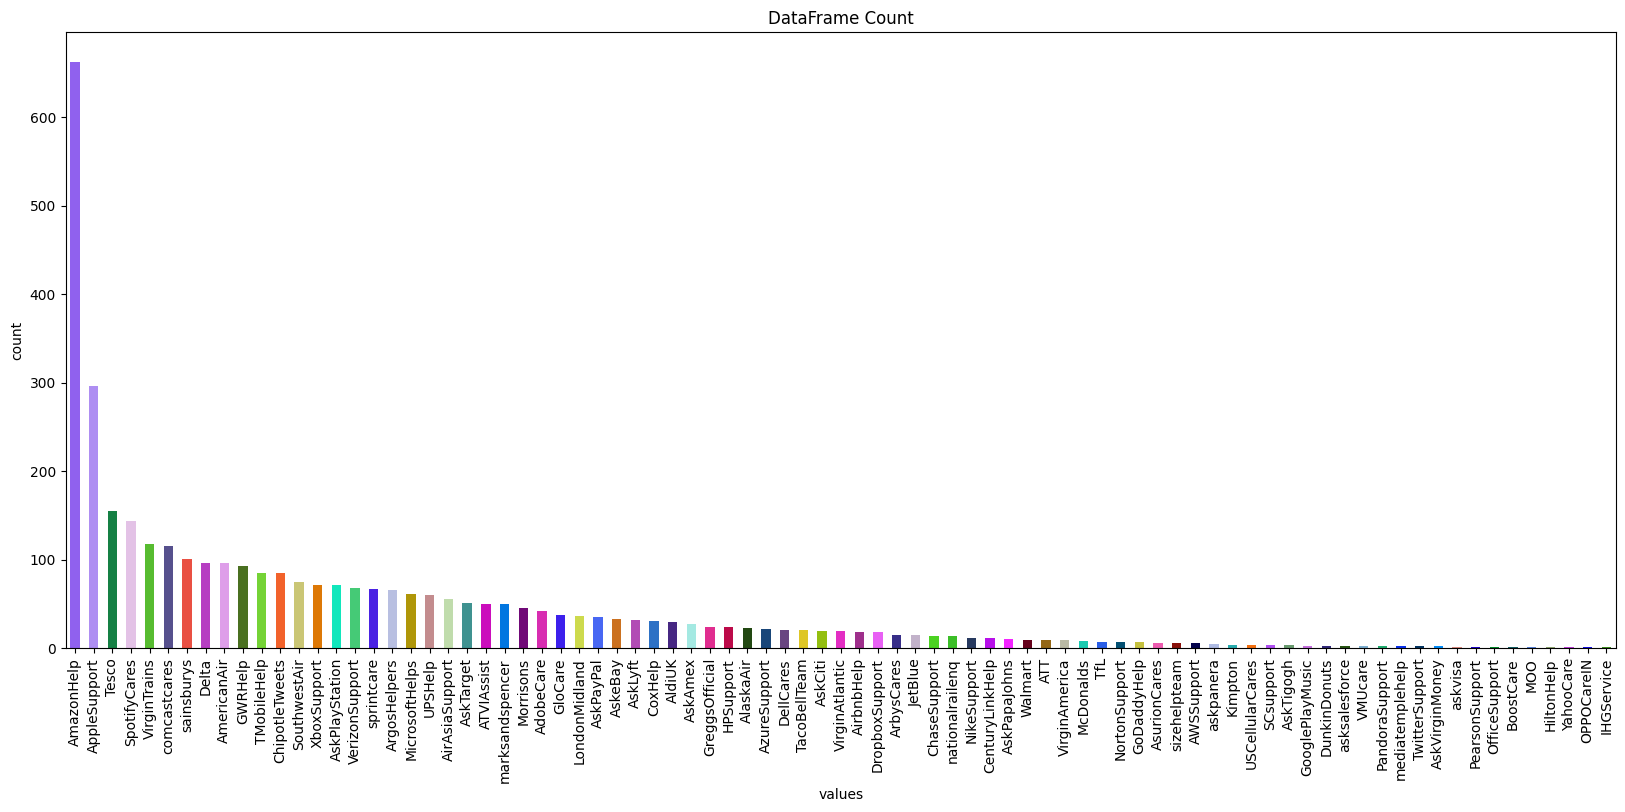

In [143]:
# 'author_id' 값들의 개수를 세어줍니다.
value_counts = english_only_df['author_id'].value_counts()

# 랜덤 색상을 생성합니다.
num_unique_values = len(value_counts)
colors = np.random.rand(num_unique_values, 3)

# 바 그래프를 생성합니다.
plt.figure(figsize=(20, 8))  # x축 크기를 늘립니다.
value_counts.plot(kind='bar', color=colors)
plt.xticks(rotation=90)  # x축 라벨을 세로로 회전시킵니다.
plt.xlabel('values')
plt.ylabel('count')
plt.title('DataFrame Count')
plt.show()

In [144]:
english_only_text_df = english_only_df[['author_id', 'text']]
english_only_text_df

,author_id,text
20358,UPSHelp,@121739 Is there something we can assist you w...
56341,SpotifyCares,@131862 Hey Amy! We're here to help. Can you D...
20405,comcastcares,@121754 I just wanted to follow up with you an...
48496,AskPayPal,@129724 Hello- Thanks for reaching out. Please...
57942,AldiUK,@132307 @132308 We'd love to hear the pitter-p...
...,...,...
10714,AdobeCare,@119122 Let us know if you need any help! ^RB
43477,AskAmex,"@128286 Good afternoon, thanks for reaching ou..."
35023,VirginTrains,@125860 If there is a last minute change in pl...
7747,sprintcare,"@118160 We want to help you, in order for us t..."


In [145]:
# 데이터 전처리 함수들
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()

    # 구두점 제거
    punc_to_remove = string.punctuation
    text = text.translate(str.maketrans('', '', punc_to_remove))

    # 불용어 제거
    STOPWORDS = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in STOPWORDS])

    # 자주 사용하는 용어 제거
    cnt = Counter(text.split())
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    text = " ".join([word for word in text.split() if word not in FREQWORDS])

    # 어간 추출
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])

    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    pos_tagged_text = nltk.pos_tag(text.split())
    wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
    text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

    return text

# 'text' 열에 전처리 적용
numbers_only_df['text'] = numbers_only_df['text'].apply(preprocess_text)
english_only_df['text'] = english_only_df['text'].apply(preprocess_text)

In [147]:
# 토큰화 함수를 정의합니다.
def tokenize_text(text):
    return word_tokenize(text)

# 토큰화된 데이터를 저장할 새로운 열을 만들고, 토큰화를 수행합니다.
numbers_only_df['tokenized_text'] = numbers_only_df['text'].apply(tokenize_text)
# 토큰화된 데이터를 저장할 새로운 열을 만들고, 토큰화를 수행합니다.
english_only_df['tokenized_eng_text'] = english_only_df['text'].apply(tokenize_text)

          author_id                                    text_lemmatized  \
7429   AzureSupport  @118055 If you would like to get back in touch...   
29225    AmazonHelp  @124158 I'm sorry your parcel arrive in this c...   
95469  ArgosHelpers  @142996 It's rat 4.8/5 so pretty good! You can...   
60853         Tesco  @133064 Sorry Lauren, do they give you the cor...   
60897       GWRHelp  @133072 That's great to hear Amanda! I'll make...   

                                          tokenized_text  
7429   [@, 118055, If, you, would, like, to, get, bac...  
29225  [@, 124158, I, 'm, sorry, your, parcel, arrive...  
95469  [@, 142996, It, 's, rat, 4.8/5, so, pretty, go...  
60853  [@, 133064, Sorry, Lauren, ,, do, they, give, ...  
60897  [@, 133072, That, 's, great, to, hear, Amanda,...  


In [160]:
numbers_only_df = numbers_only_df[['author_id','tokenized_text']]
numbers_only_df.head(5)

,author_id,tokenized_text
50379,130265,"[problem, nope, applesupport, still]"
17297,120880,"[earlier, respons, airasiasupport, case00231766]"
70878,135867,"[custom, servic, poorcustomerservic]"
9650,118781,"[work, great, i, ’, ll, call, custom, servic, ..."
26206,123336,"[everyth, like, gmail, ok]"


In [163]:
english_only_df = english_only_df[['author_id','tokenized_eng_text']]
english_only_df.head(5)

,author_id,tokenized_eng_text
20358,UPSHelp,[httpstcowkjhdxwgrq]
56341,SpotifyCares,"[well, see, suggest, km, httpstcoldfdzrinat]"
57942,AldiUK,"[🥕, glad, ad, kevinandkati]"
73431,AppleSupport,"[step, perform, error, httpstcolmmvpdjgnn]"
29865,TMobileHelp,"[dm, kaew]"


In [164]:
# 'numbers_only_df'에서 빈 문자열과 '[]'를 결측치로 처리하고 제거합니다.
numbers_only_df = numbers_only_df.replace("", np.nan)
numbers_only_df = numbers_only_df.replace("[]", np.nan)
numbers_only_df = numbers_only_df.dropna()

# 'english_only_df'에서 빈 문자열과 '[]'를 결측치로 처리하고 제거합니다.
english_only_df = english_only_df.replace("", np.nan)
english_only_df = english_only_df.replace("[]", np.nan)
english_only_df = english_only_df.dropna()

In [165]:
# 결과 확인
numbers_only_df.head()

,author_id,tokenized_text
50379,130265,"[problem, nope, applesupport, still]"
17297,120880,"[earlier, respons, airasiasupport, case00231766]"
70878,135867,"[custom, servic, poorcustomerservic]"
9650,118781,"[work, great, i, ’, ll, call, custom, servic, ..."
26206,123336,"[everyth, like, gmail, ok]"


In [166]:
english_only_df.head()

,author_id,tokenized_eng_text
20358,UPSHelp,[httpstcowkjhdxwgrq]
56341,SpotifyCares,"[well, see, suggest, km, httpstcoldfdzrinat]"
57942,AldiUK,"[🥕, glad, ad, kevinandkati]"
73431,AppleSupport,"[step, perform, error, httpstcolmmvpdjgnn]"
29865,TMobileHelp,"[dm, kaew]"


In [170]:
# 전체 데이터프레임의 토큰화된 텍스트 열 가져오기
tokens_list = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()

# 모든 토큰들을 하나의 리스트로 통합
all_tokens = [token for tokens in tokens_list for token in tokens]

# 토큰들의 빈도수를 계산하여 단어 집합 생성
word_counter_num = Counter(all_tokens)
word_vocab_num = {word: idx for idx, (word, _) in enumerate(word_counter_num.items())}

print(word_vocab_num)

{'problem': 0, 'nope': 1, 'applesupport': 2, 'still': 3, 'earlier': 4, 'respons': 5, 'airasiasupport': 6, 'case00231766': 7, 'custom': 8, 'servic': 9, 'poorcustomerservic': 10, 'work': 11, 'great': 12, 'i': 13, '’': 14, 'll': 15, 'call': 16, 'wait': 17, 'nearli': 18, 'hr': 19, 'disconnect': 20, 'everyth': 21, 'like': 22, 'gmail': 23, 'ok': 24, 'perform': 25, 'hour': 26, 'suppos': 27, '45hr': 28, 'excess': 29, 'serv': 30, 'airlin': 31, 'consum': 32, 'dm': 33, 'resolv': 34, 'situat': 35, 'way': 36, 'muchli': 37, 'm': 38, 'disabl': 39, 'thx': 40, 'doubt': 41, 'spectrumsdownagain': 42, 'httpstcouyuyki30rl': 43, 'letter': 44, '“': 45, 'i️': 46, '”': 47, 'amp': 48, 'remvd': 49, 'cart': 50, 'go': 51, 'help': 52, 'hpcswu': 53, 'hpprnt': 54, 'detail': 55, 'verifi': 56, 'sheerid': 57, '13th': 58, 'nov': 59, 'howev': 60, 'moment': 61, 'forget': 62, 'click': 63, 'link': 64, 'email': 65, 'final': 66, 'process': 67, 'late': 68, 'week': 69, 'time': 70, 'rebook': 71, 'u': 72, 'asap': 73, 'precaut': 74

In [190]:
# 워드임베딩 실행
# 데이터셋의 토큰화된 텍스트 열 가져오기 (예시로 numbers_only_df의 tokenized_text 사용)
tokens_list_emb = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()

# Word2Vec 모델 학습
tokens_list_emb = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()
model_word2vec = Word2Vec(sentences=tokens_list_emb, vector_size=100, window=5, min_count=1, sg=1)

# Word2Vec 모델의 단어와 임베딩 벡터 매핑
word_vocab_num = {word: idx for idx, word in enumerate(model_word2vec.wv.index_to_key)}
word_embeddings = model_word2vec.wv.vectors

# 워드 임베딩 적용 결과 출력
print("Word Embeddings Shape:", word_embeddings.shape)

Word Embeddings Shape: (6806, 100)


In [191]:
word_embeddings

array([[-1.7581308e-01,  1.8885724e-01,  4.5738511e-02, ...,
        -3.6821711e-01,  3.5971496e-02, -7.3327653e-02],
       [-1.5037060e-01,  1.6084488e-01,  1.9676539e-03, ...,
        -2.8307915e-01,  2.3401727e-03, -7.6687537e-02],
       [-1.5229213e-01,  1.6065072e-01, -1.2124160e-02, ...,
        -3.1641117e-01,  3.4723863e-02, -1.0665659e-01],
       ...,
       [-2.0773970e-02,  2.9353176e-03,  3.0321751e-03, ...,
        -1.9196095e-02,  3.2081732e-03, -1.0123287e-02],
       [-8.0315424e-03,  1.8550985e-02, -1.2454526e-03, ...,
        -2.0580351e-02,  7.1050040e-03, -1.1389686e-02],
       [-5.9594512e-03,  2.9288174e-04,  6.5013850e-03, ...,
         4.3318332e-03,  1.3465858e-03, -2.0984674e-03]], dtype=float32)

In [193]:
# 훈련셋과 검증셋 분리
X = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()
y = [0] * len(numbers_only_df) + [1] * len(english_only_df)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터를 정수 시퀀스로 변환
X_train = [[word_vocab_num[word] for word in tokens] for tokens in X_train]
X_val = [[word_vocab_num[word] for word in tokens] for tokens in X_val]

# 패딩 처리
max_sequence_length = max(len(seq) for seq in X_train + X_val)  # 최대 시퀀스 길이
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_sequence_length, padding='post')

# LSTM 모델 구성
embedding_dim = 100  # 임베딩 벡터의 차원
vocab_size = len(word_vocab_num)  # 단어 집합의 크기

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, weights=[word_embeddings]))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

ValueError: ignored